In [1]:
%load_ext autoreload
%autoreload 2

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

import pandas as pd
import math
import numpy as np
import datetime
from time import time
from functools import reduce
from matplotlib import pyplot as plt
from soccerlearn.features import *
    
import plotly.graph_objs as go
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
init_notebook_mode(connected=True)


SMALL_SIZE=13
MEDIUM_SIZE=SMALL_SIZE+5
BIGGER_SIZE=MEDIUM_SIZE+5

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=MEDIUM_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title
plt.rc('figure', dpi=150)

league_to_files = {
    'La Liga': {
        'standings': '../data/standings_La Liga.csv',        
        'seasons': '../data/seasons.csv',
        'teams': '../data/teams_league_La Liga.csv',
        'fixtures': '../data/fixtures_and_odds_La Liga_2018-07-01_2020-07-01.csv',
    },
    'Premier League': {
        'standings': '../data/standings_Premier League.csv',
        'seasons': '../data/seasons.csv',
        'teams': '../data/teams_league_Premier League.csv',
        'fixtures': '../data/fixtures_and_odds_Premier League_2014-07-01_2020-07-01.csv',    
    },
}


In [2]:
league_name = 'La Liga'
season_data = pd.read_csv(league_to_files[league_name]['seasons']).rename(columns={'id': 'season_id', 'name': 'season_name'})
team_data = pd.read_csv(league_to_files[league_name]['teams']).groupby('id').first().reset_index()
fixtures_and_odds = pd.read_csv(league_to_files[league_name]['fixtures'])
fixtures_and_odds['date_time'] = pd.to_datetime(fixtures_and_odds['time'].apply(lambda x: eval(x)['starting_at']['date_time']))
print(fixtures_and_odds.shape)
fixtures_and_odds = pd.merge(
    fixtures_and_odds,
    team_data[['name', 'id']].add_prefix('localteam_'),
    on='localteam_id'
)
print(fixtures_and_odds.shape)
fixtures_and_odds = pd.merge(
    fixtures_and_odds,
    team_data[['name', 'id']].add_prefix('visitorteam_'),
    on='visitorteam_id'
)
overall_probability = fixtures_and_odds.groupby(['bookmaker_name', 'id'])['odd_value'].apply(lambda x: (1 / x).sum()).rename('overall_probability').reset_index()
fixtures_and_odds = pd.merge(
    fixtures_and_odds,
    overall_probability,
    on=['bookmaker_name', 'id'],
)
print(fixtures_and_odds.shape)
fixtures_and_odds.head()

(12999, 34)
(12999, 35)
(12879, 37)


,id,league_id,season_id,stage_id,round_id,group_id,aggregate_id,venue_id,referee_id,localteam_id,...,deleted,flatOdds,odd_name,odd_value,odd_winning,bookmaker_name,date_time,localteam_name,visitorteam_name,overall_probability
0,10367580,564,13133,7743270,151245,NaN,NaN,9345,13525.0,231,...,False,"[{'bookmaker_id': 2, 'bookmaker_event_id': Non...",1,2.00,False,bet365,2018-08-17 20:15:00,Girona,Real Valladolid,1.127193
1,10367580,564,13133,7743270,151245,NaN,NaN,9345,13525.0,231,...,False,"[{'bookmaker_id': 2, 'bookmaker_event_id': Non...",X,2.40,True,bet365,2018-08-17 20:15:00,Girona,Real Valladolid,1.127193
2,10367580,564,13133,7743270,151245,NaN,NaN,9345,13525.0,231,...,False,"[{'bookmaker_id': 2, 'bookmaker_event_id': Non...",2,4.75,False,bet365,2018-08-17 20:15:00,Girona,Real Valladolid,1.127193
3,10367580,564,13133,7743270,151245,NaN,NaN,9345,13525.0,231,...,False,"[{'bookmaker_id': 2, 'bookmaker_event_id': Non...",1,2.11,False,Marathonbet,2018-08-17 20:15:00,Girona,Real Valladolid,1.075954
4,10367580,564,13133,7743270,151245,NaN,NaN,9345,13525.0,231,...,False,"[{'bookmaker_id': 2, 'bookmaker_event_id': Non...",2,4.95,False,Marathonbet,2018-08-17 20:15:00,Girona,Real Valladolid,1.075954


In [3]:
fixtures_unpivoted = unpivot_fixtures_by_odds({'fixtures': fixtures_and_odds})
print(fixtures_unpivoted.shape)
fixtures_unpivoted.head()

(640, 125)


,id,league_id,season_id,stage_id,round_id,group_id,aggregate_id,venue_id,referee_id,localteam_id,...,odd_winning_X_BetVictor,odd_winning_X_Betfair,odd_winning_X_Ladbrokes,odd_winning_X_Marathon,odd_winning_X_Marathonbet,odd_winning_X_Pncl,odd_winning_X_Unibet,odd_winning_X_WilliamHill,odd_winning_X_bet365,odd_winning_X_bwin
0,10367580,564,13133,7743270,151245,NaN,NaN,9345,13525.0,231,...,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,1.0,NaN
1,10420485,564,13133,7743270,151253,NaN,NaN,68,17909.0,485,...,NaN,NaN,NaN,NaN,1.0,NaN,NaN,1.0,1.0,NaN
2,11895808,564,16326,77444988,175869,NaN,NaN,68,18789.0,485,...,NaN,0.0,0.0,0.0,NaN,NaN,NaN,0.0,NaN,0.0
3,10420445,564,13133,7743270,151249,NaN,NaN,9239,14318.0,36,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,11895948,564,16326,77444988,175883,NaN,NaN,9239,17909.0,36,...,NaN,1.0,1.0,1.0,NaN,NaN,NaN,NaN,1.0,1.0


In [26]:
fixtures_unpivoted.iloc[0].keys().tolist()

['id',
 'league_id',
 'season_id',
 'stage_id',
 'round_id',
 'group_id',
 'aggregate_id',
 'venue_id',
 'referee_id',
 'localteam_id',
 'visitorteam_id',
 'winner_team_id',
 'weather_report',
 'commentaries',
 'attendance',
 'pitch',
 'details',
 'neutral_venue',
 'winning_odds_calculated',
 'formations',
 'scores',
 'time',
 'coaches',
 'standings',
 'assistants',
 'leg',
 'colors',
 'deleted',
 'flatOdds',
 'bookmaker_name',
 'date_time',
 'localteam_name',
 'visitorteam_name',
 'overall_probability',
 'odd_name_bookmaker',
 'odd_value_1_10Bet',
 'odd_value_1_1xbet',
 'odd_value_1_BetCRIS',
 'odd_value_1_BetFred',
 'odd_value_1_BetRedKings',
 'odd_value_1_BetVictor',
 'odd_value_1_Betfair',
 'odd_value_1_Ladbrokes',
 'odd_value_1_Marathon',
 'odd_value_1_Marathonbet',
 'odd_value_1_Pncl',
 'odd_value_1_Unibet',
 'odd_value_1_WilliamHill',
 'odd_value_1_bet365',
 'odd_value_1_bwin',
 'odd_value_2_10Bet',
 'odd_value_2_1xbet',
 'odd_value_2_BetCRIS',
 'odd_value_2_BetFred',
 'odd_valu

In [36]:
# Analysing games with the largest discrepancies on odds

In [37]:
def remove_outlier_odds(odds):
    std = odds.std()
    odds.loc[odds > (3 * (std) + odds.quantile(0.6))] = np.nan
    return odds


odd_name = '1'
odd_columns = [col for col in fixtures_unpivoted.columns if f'value_{odd_name}_' in col and 'std' not in col and 'present' not in col]
fixtures_unpivoted[odd_columns] = fixtures_unpivoted[odd_columns].apply(remove_outlier_odds, axis=1)
fixtures_unpivoted[f'odd_value_{odd_name}_std'] = fixtures_unpivoted[odd_columns].std(axis=1)
fixtures_unpivoted[f'odd_value_{odd_name}_prop_present'] = fixtures_unpivoted[odd_columns].notnull().mean(axis=1)

In [38]:
largest_inconsistencies = fixtures_unpivoted.loc[fixtures_unpivoted.loc[fixtures_unpivoted[f'odd_value_{odd_name}_prop_present'] > .5 ,'odd_value_1_std'].nlargest(5).index, odd_columns]

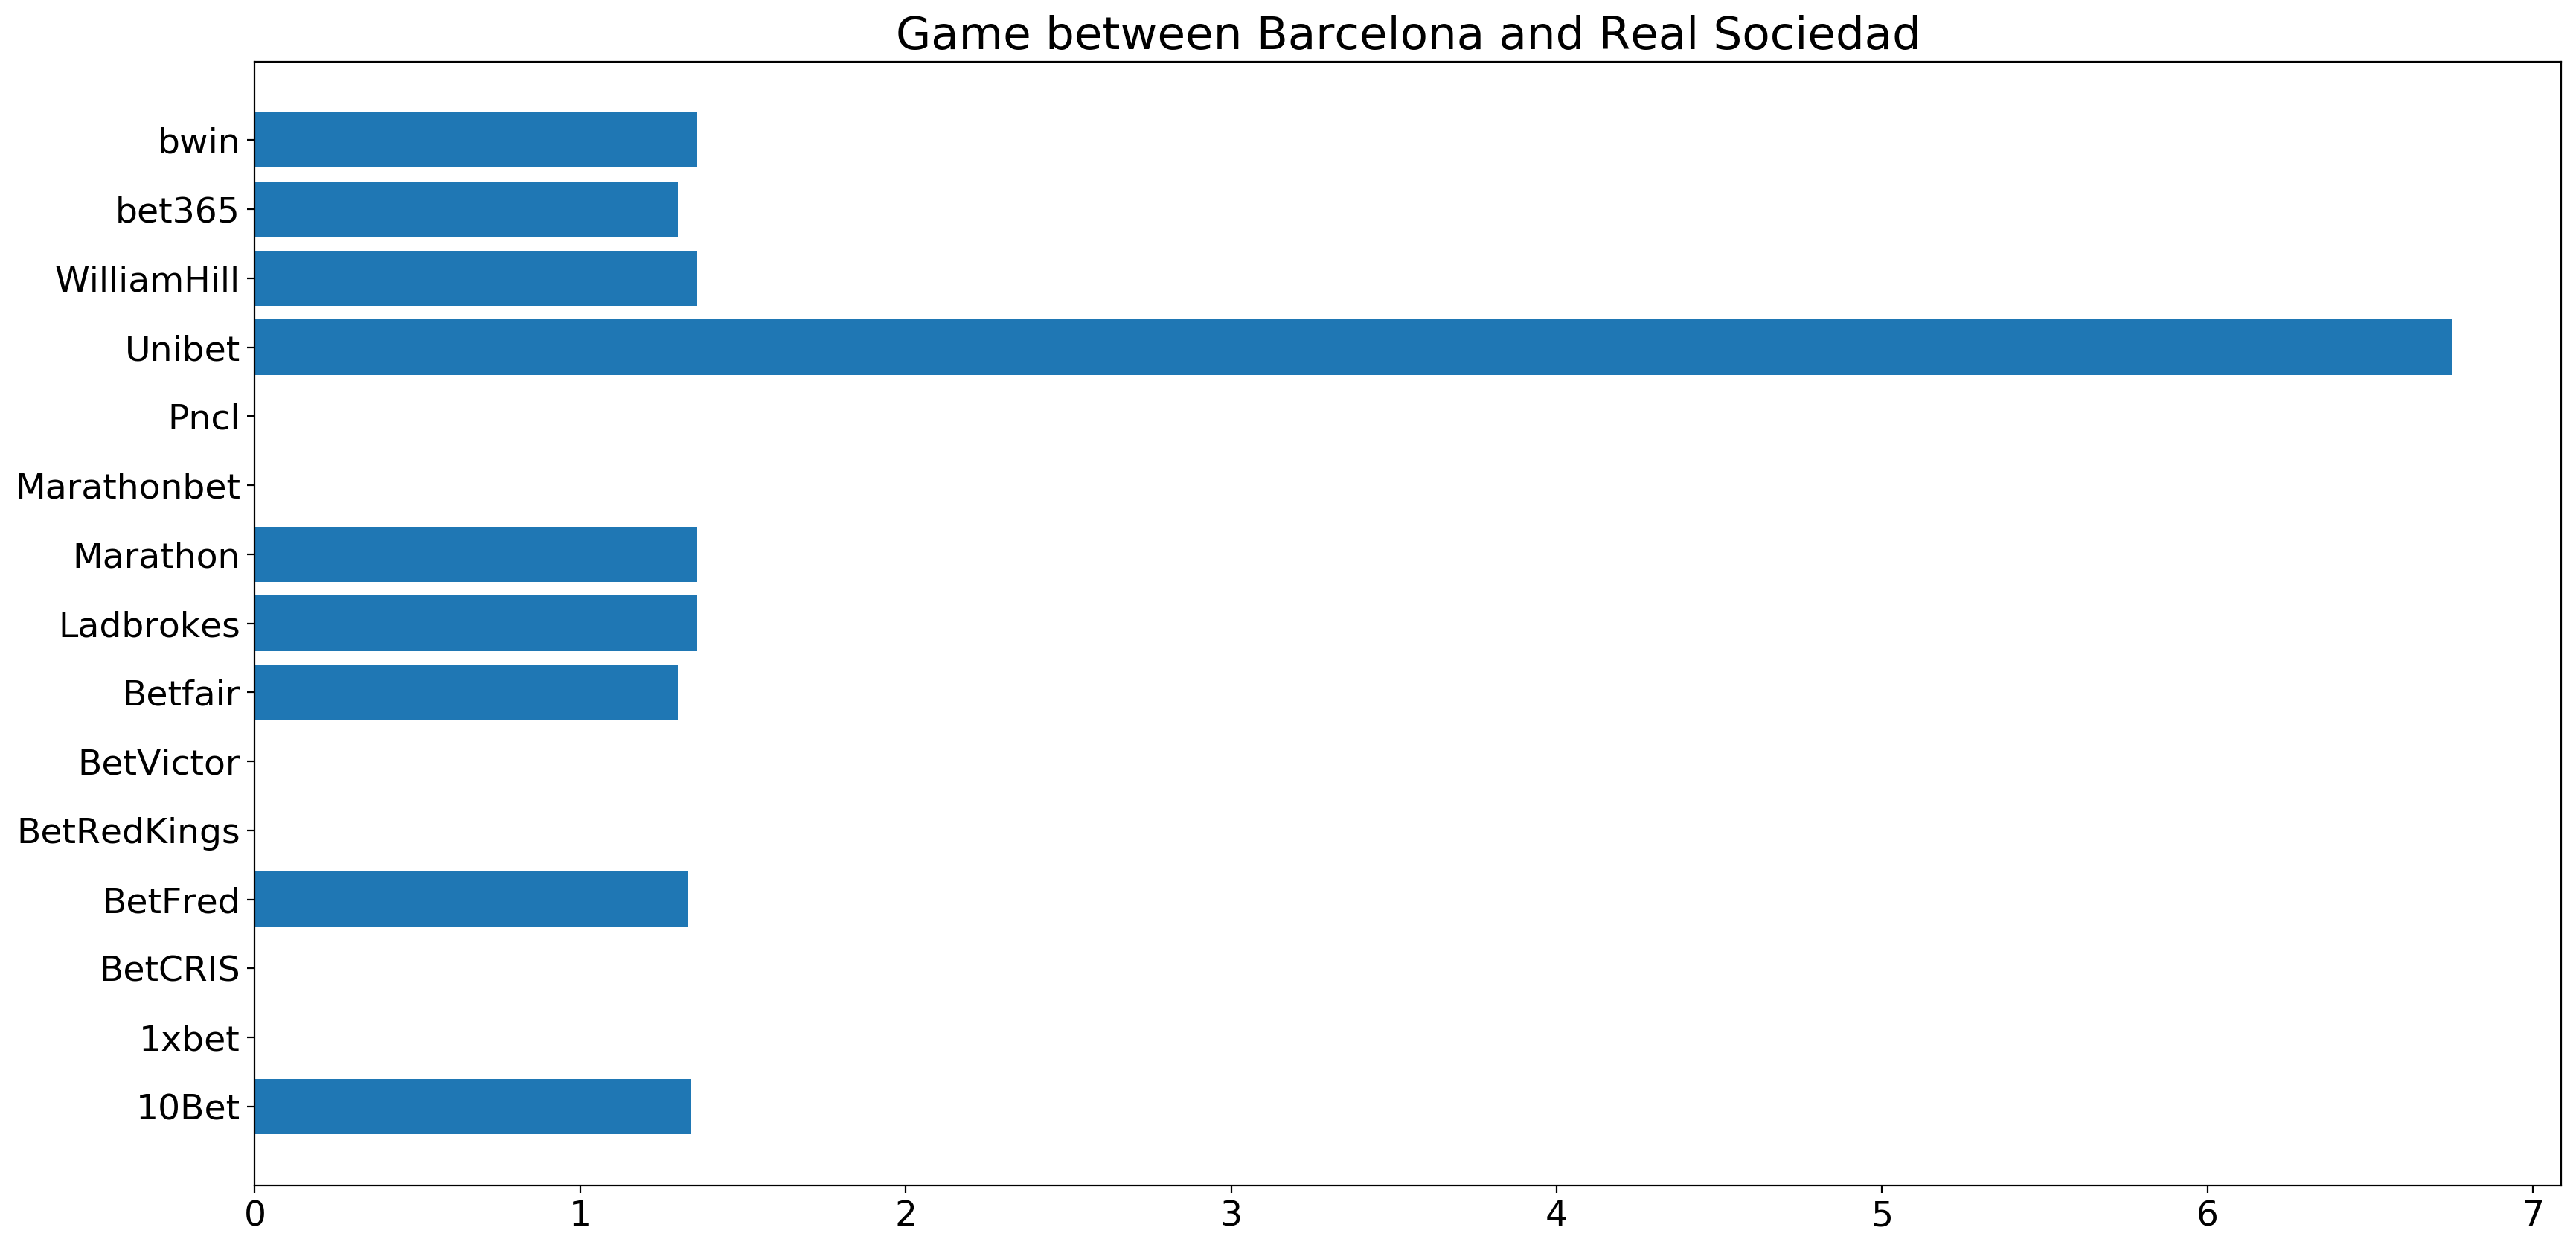

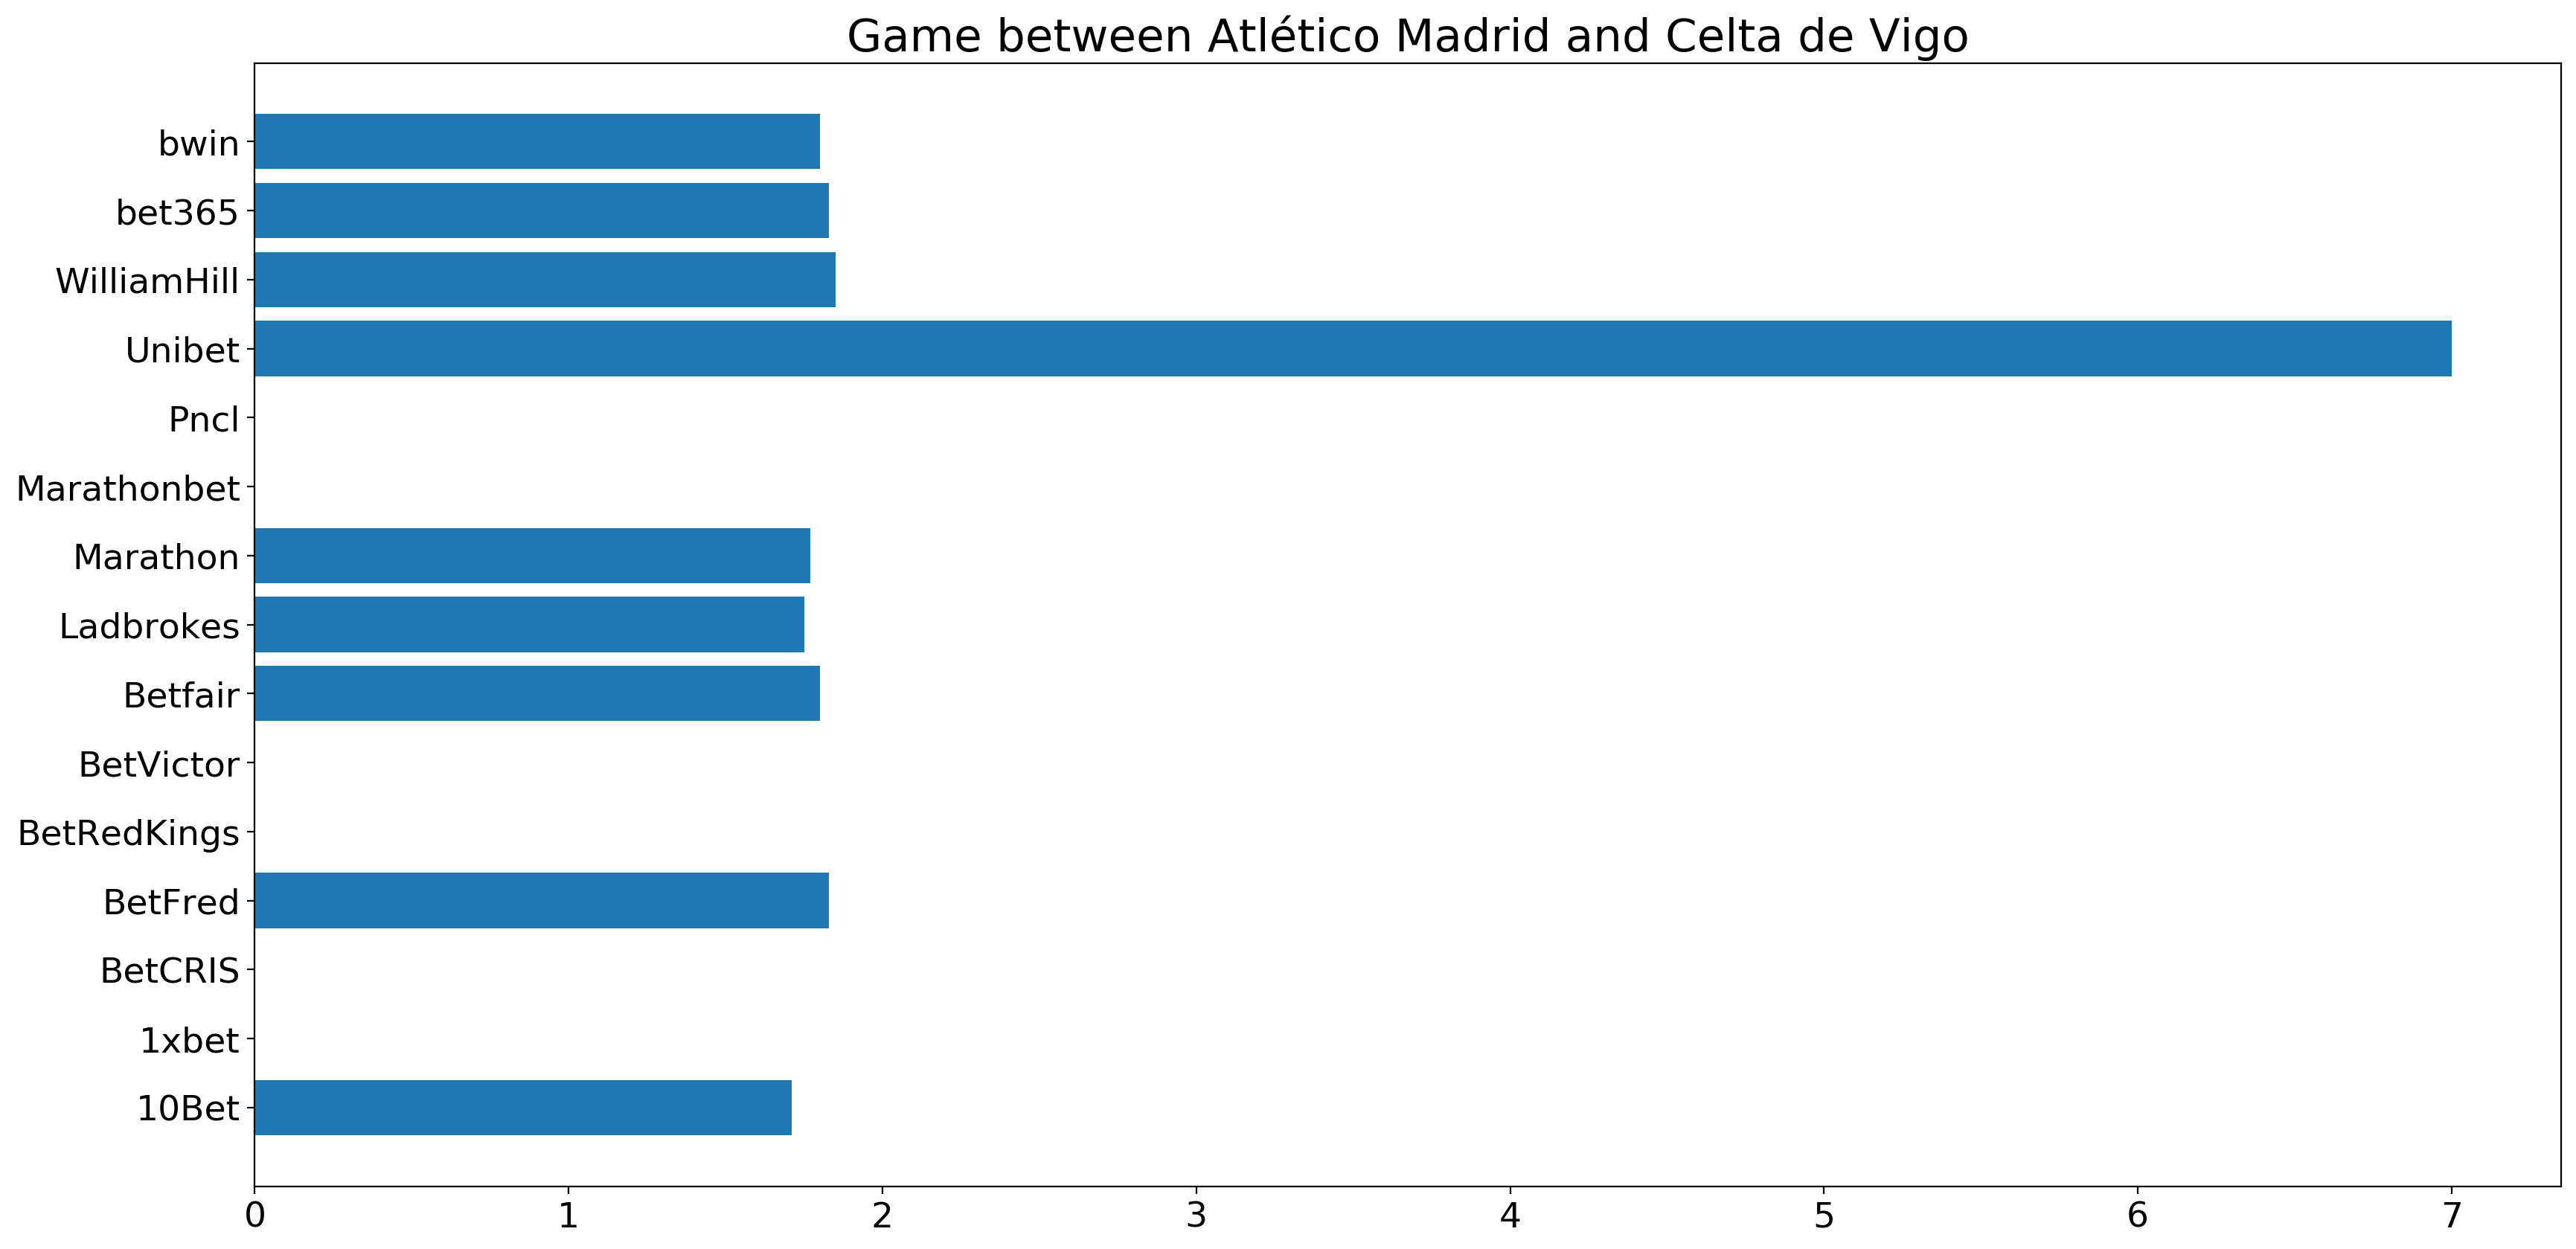

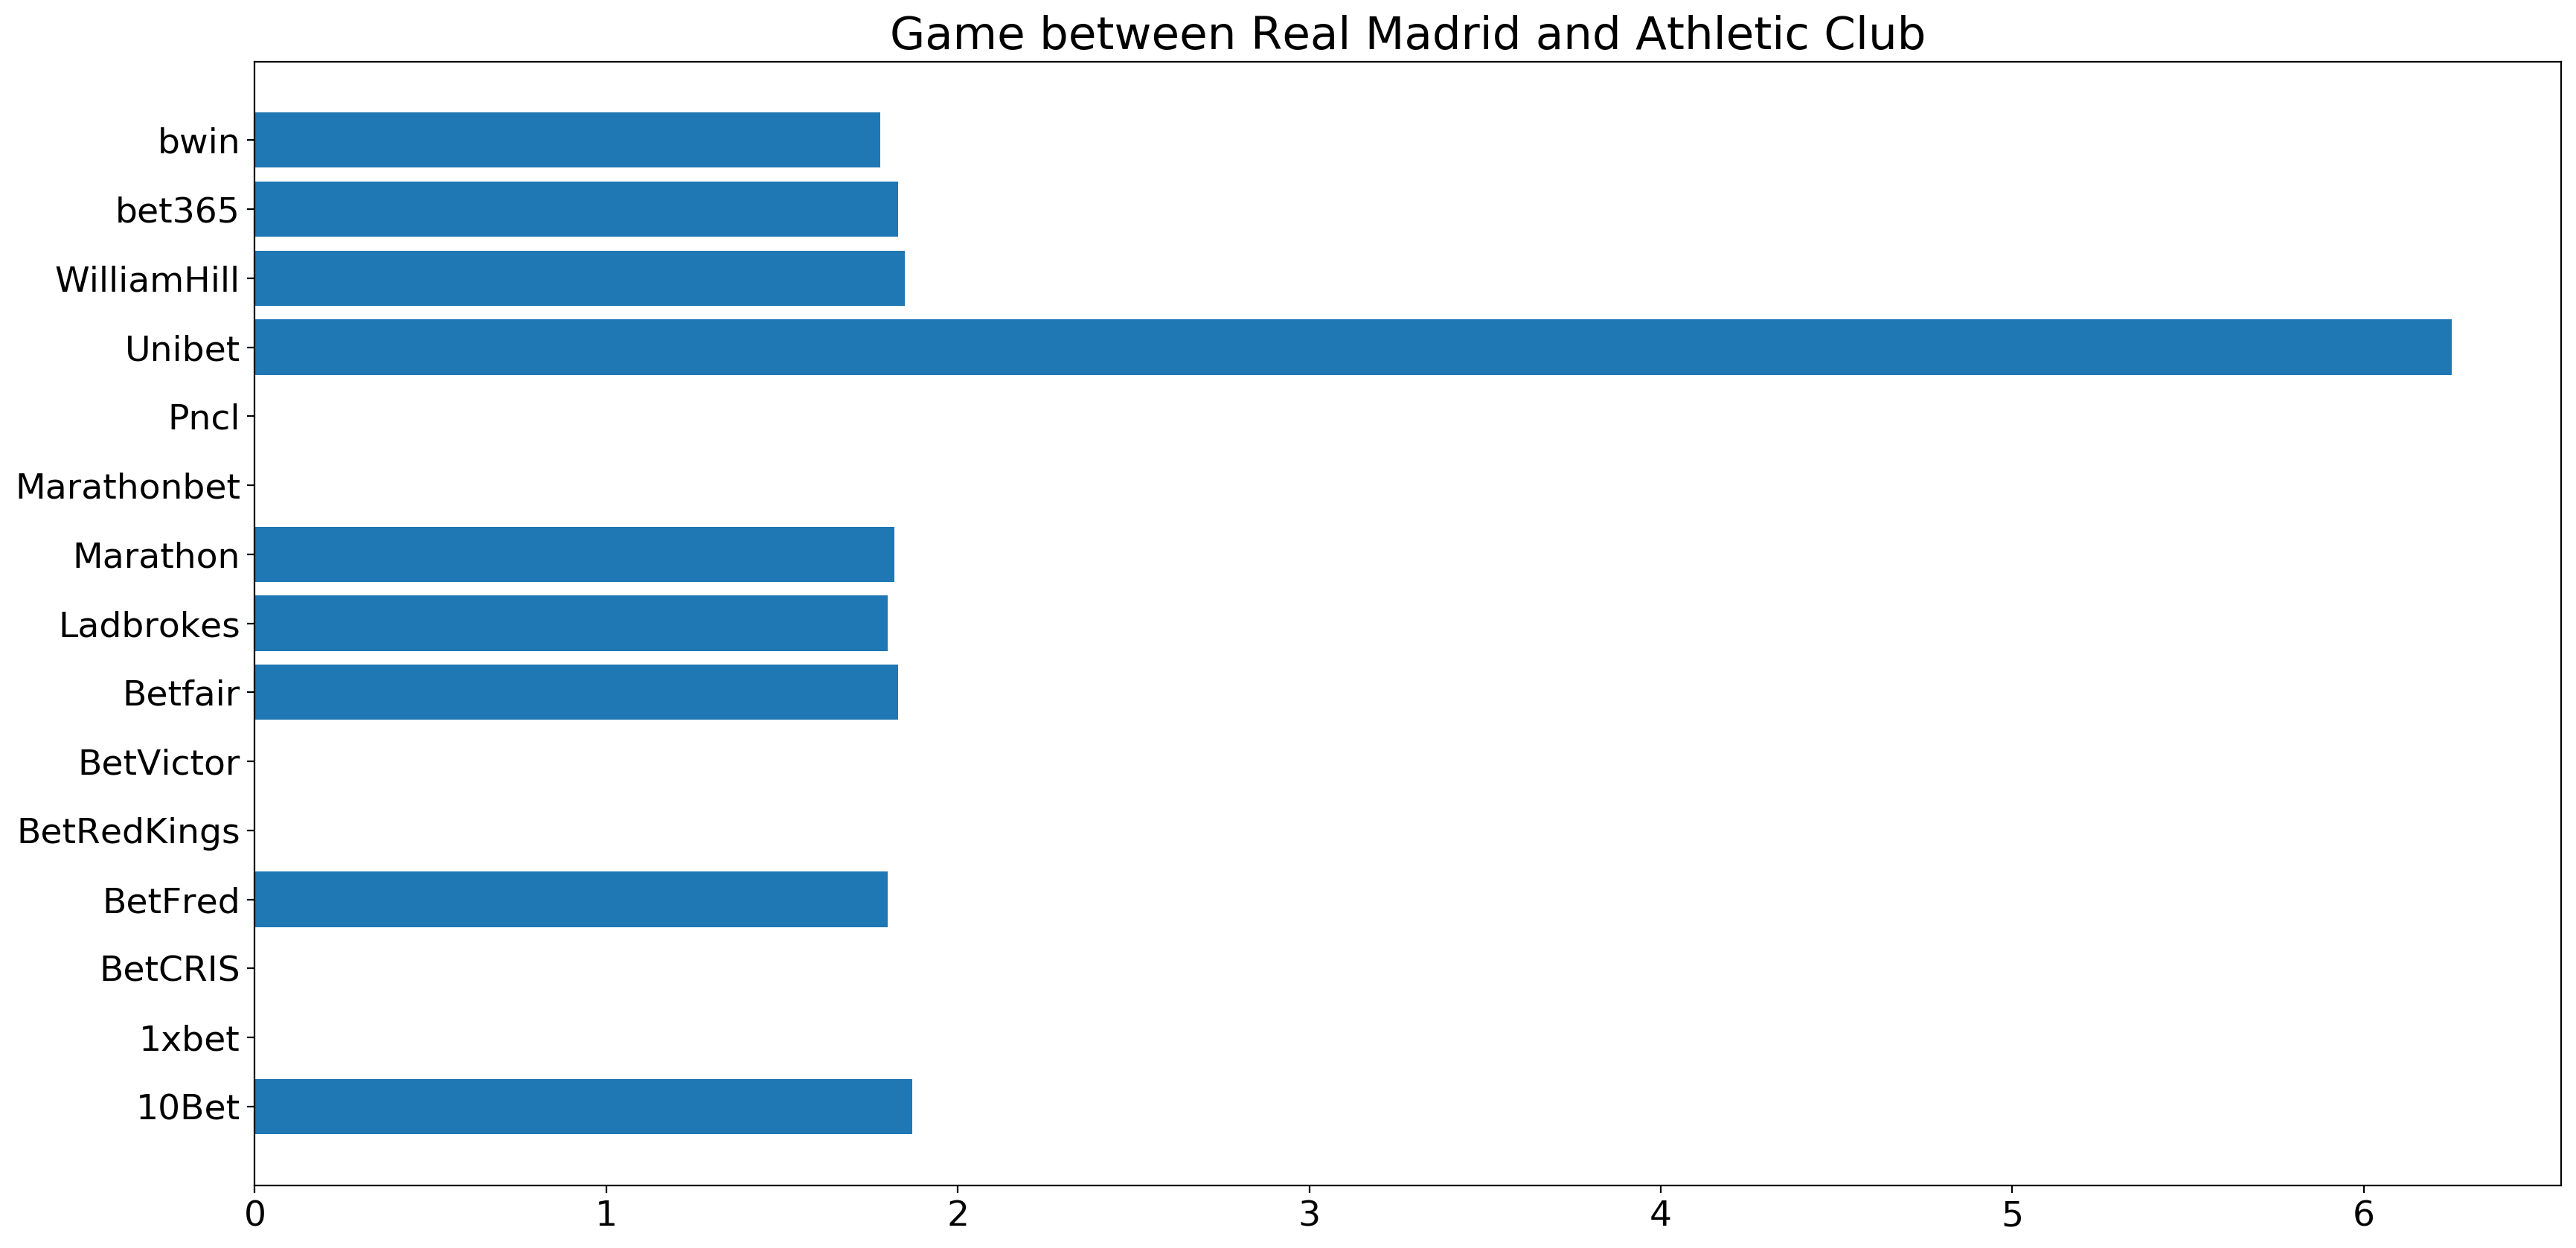

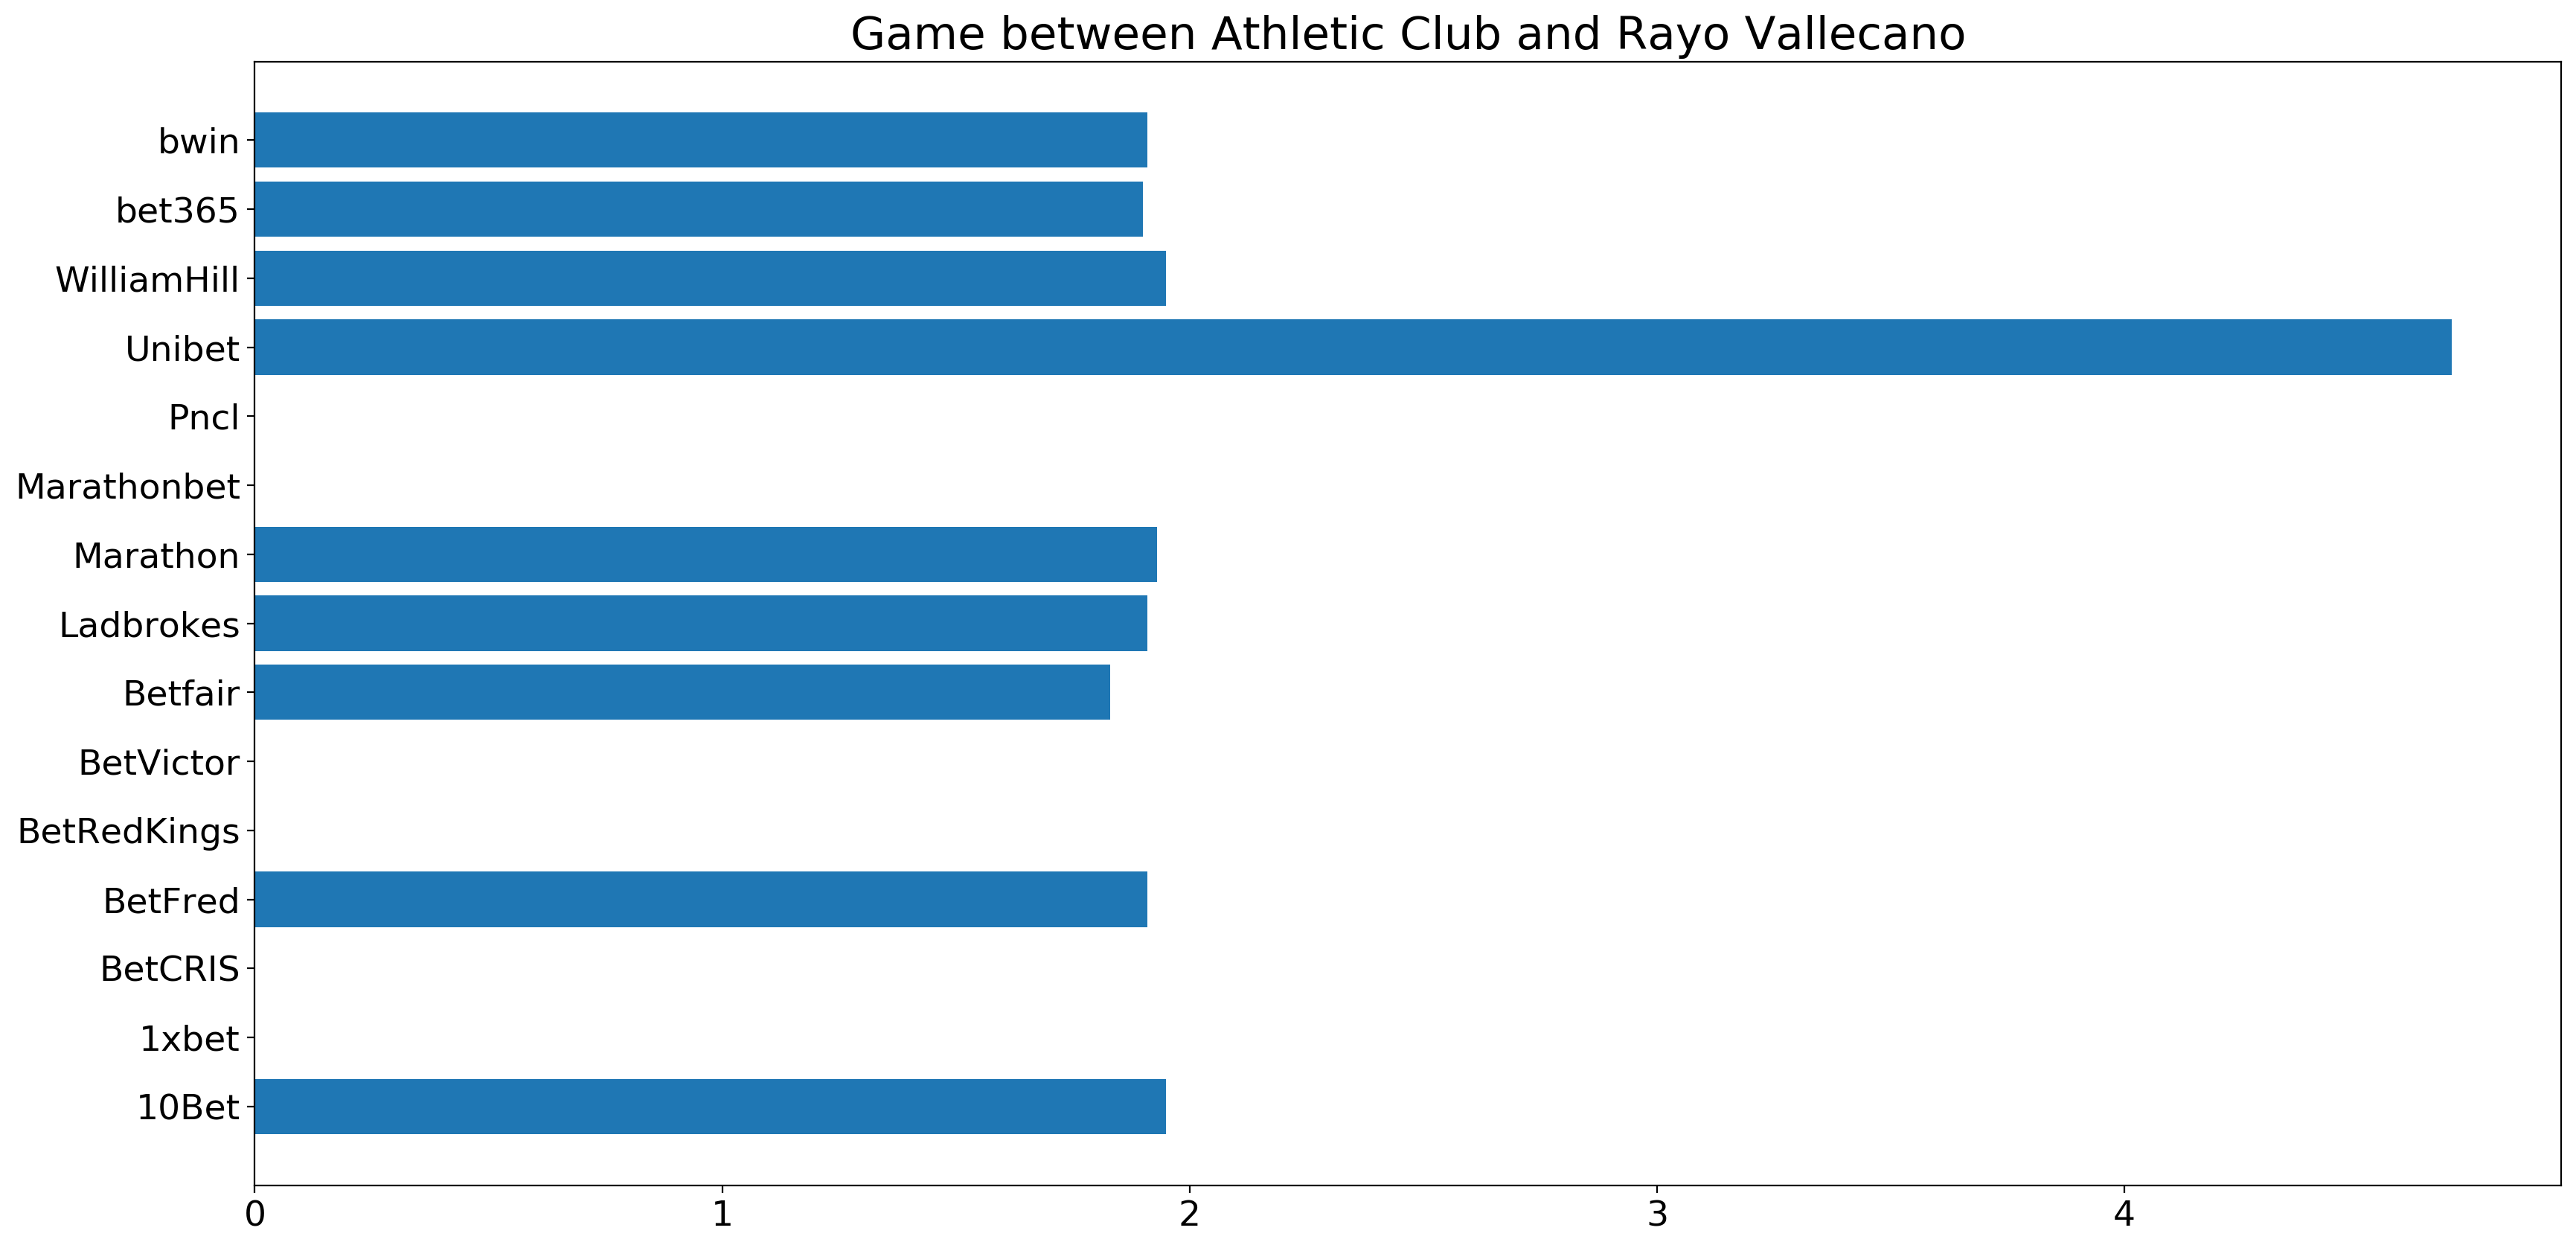

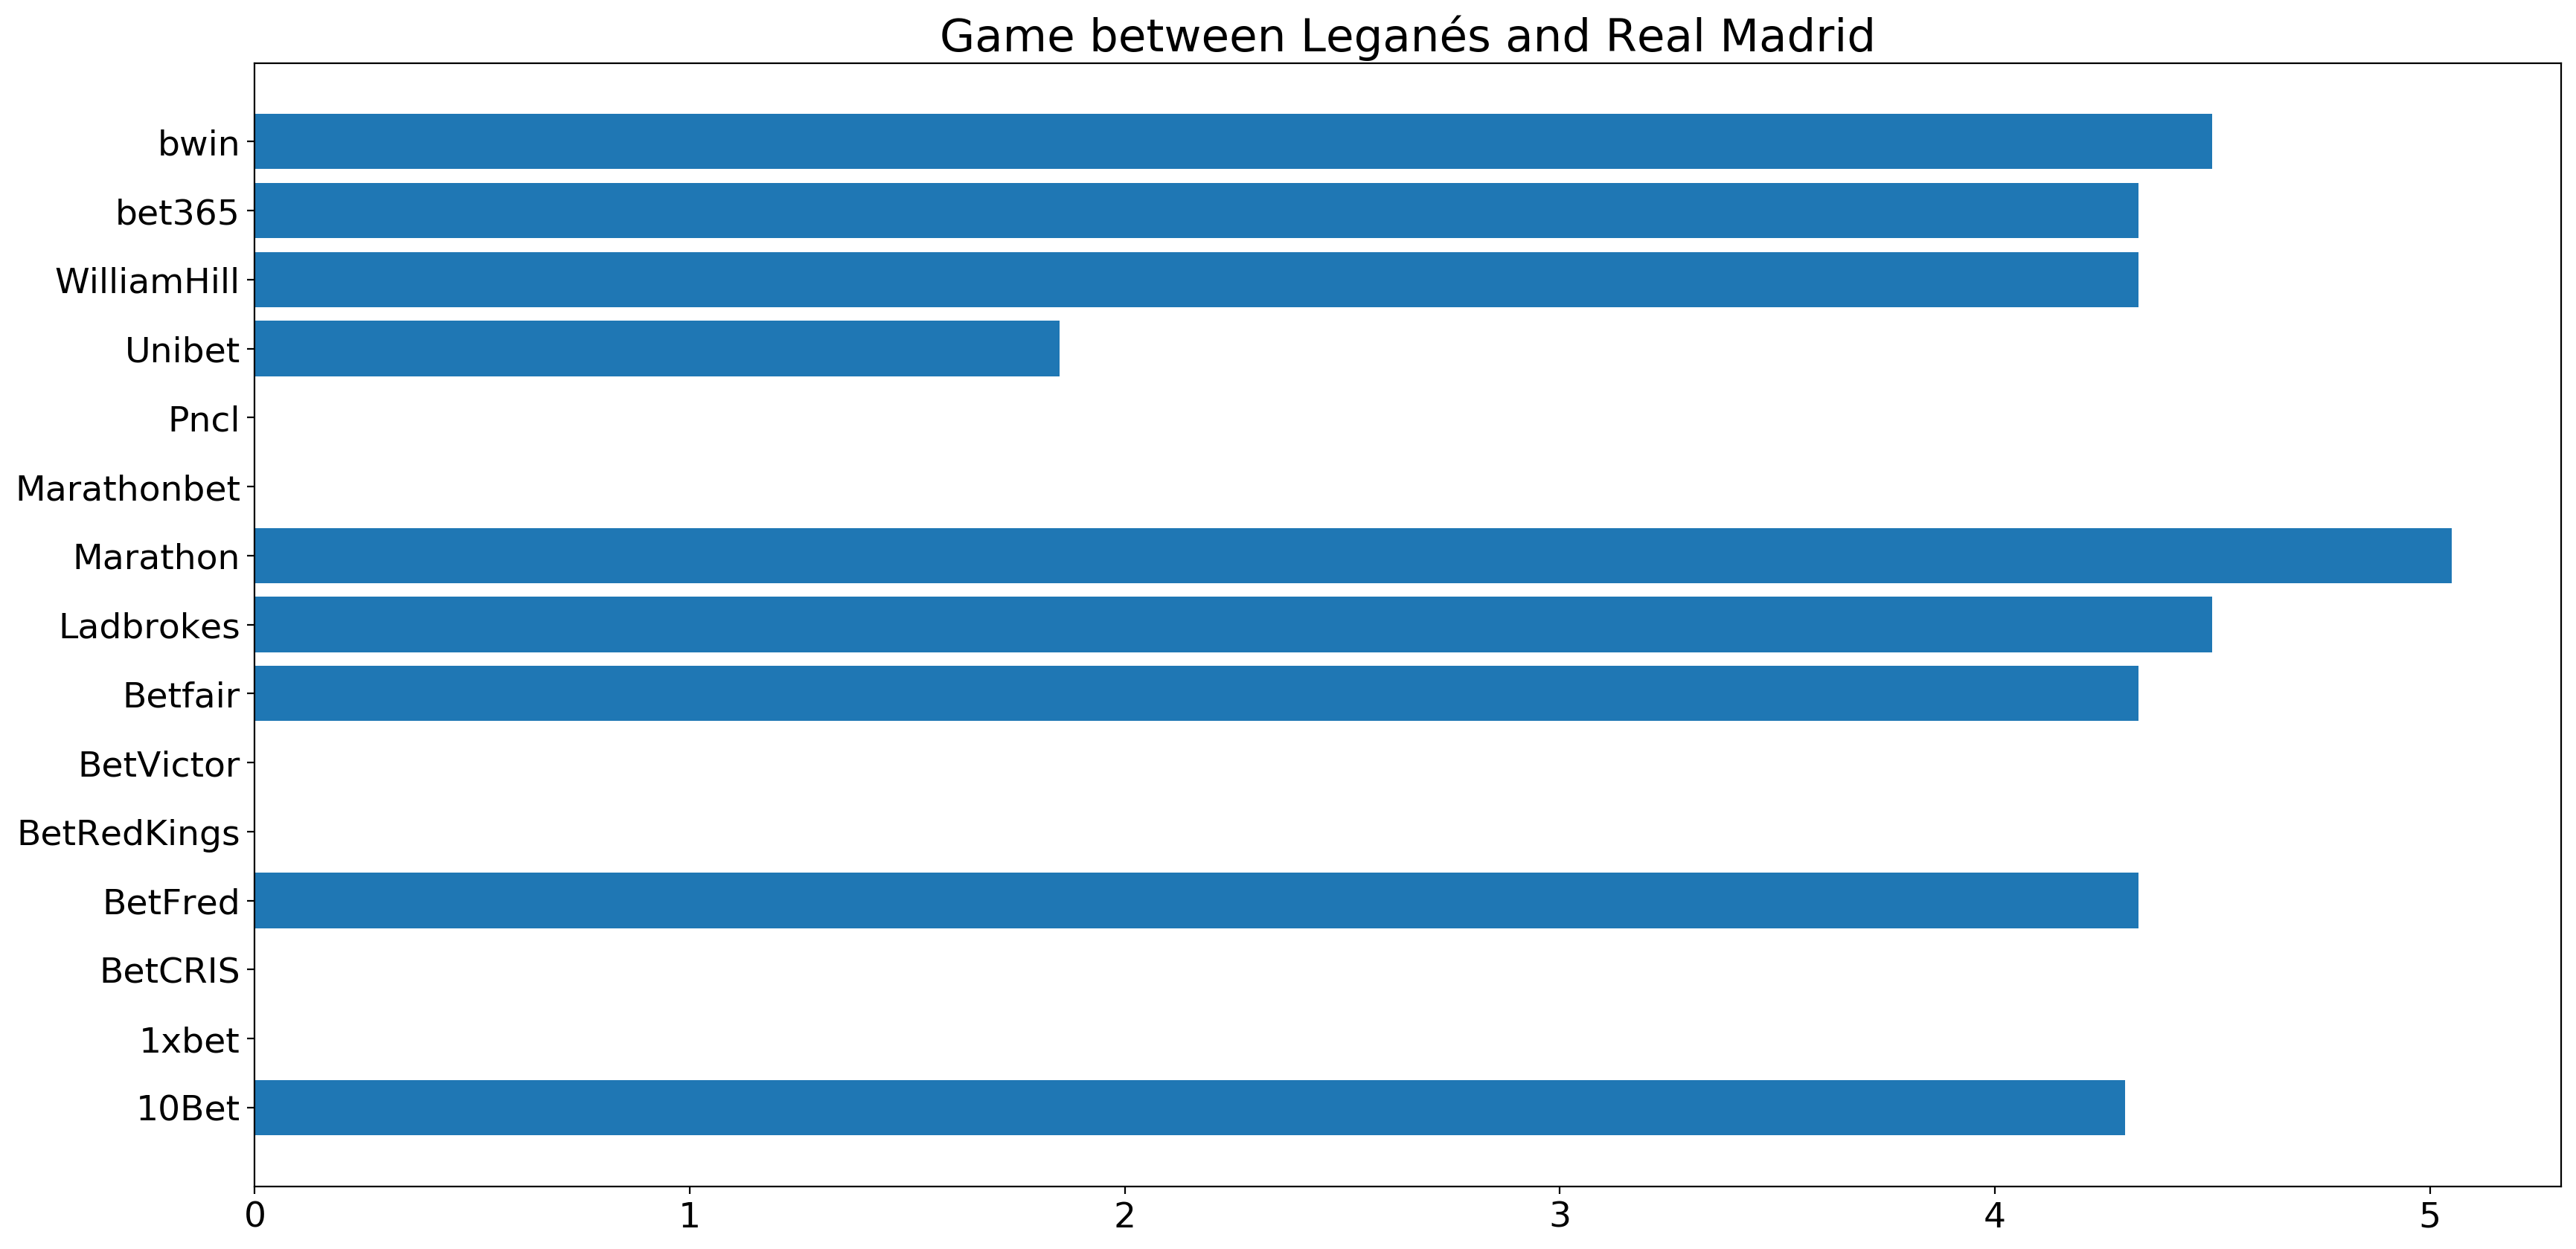

In [39]:
import seaborn as sns

for index, row in largest_inconsistencies.iterrows():
    _row = row[odd_columns]
    _row = _row.rename({col: col.split('_')[-1] for col in _row.index})
    fig, ax = plt.subplots(figsize=(20, 10))
    ax.barh(_row.index, _row.values)
    features_single_row = fixtures_unpivoted.loc[index, ['localteam_name', 'visitorteam_name']]
    plt.title(f'Game between {features_single_row.localteam_name} and {features_single_row.visitorteam_name}')
    plt.show()

bookmaker_names = _row.index

In [40]:
## Who's the cheapest/most rigged 

In [41]:
fixtures_and_odds.head()

,id,league_id,season_id,stage_id,round_id,group_id,aggregate_id,venue_id,referee_id,localteam_id,...,flatOdds,odd_name,odd_value,odd_winning,bookmaker_name,date_time,localteam_name,visitorteam_name,overall_probability,odd_name_bookmaker
0,10367580,564,13133,7743270,151245,NaN,NaN,9345,13525.0,231,...,"[{'bookmaker_id': 2, 'bookmaker_event_id': Non...",1,2.00,False,bet365,2018-08-17 20:15:00,Girona,Real Valladolid,1.127193,1_bet365
1,10367580,564,13133,7743270,151245,NaN,NaN,9345,13525.0,231,...,"[{'bookmaker_id': 2, 'bookmaker_event_id': Non...",X,2.40,True,bet365,2018-08-17 20:15:00,Girona,Real Valladolid,1.127193,X_bet365
2,10367580,564,13133,7743270,151245,NaN,NaN,9345,13525.0,231,...,"[{'bookmaker_id': 2, 'bookmaker_event_id': Non...",2,4.75,False,bet365,2018-08-17 20:15:00,Girona,Real Valladolid,1.127193,2_bet365
3,10367580,564,13133,7743270,151245,NaN,NaN,9345,13525.0,231,...,"[{'bookmaker_id': 2, 'bookmaker_event_id': Non...",1,2.11,False,Marathonbet,2018-08-17 20:15:00,Girona,Real Valladolid,1.075954,1_Marathonbet
4,10367580,564,13133,7743270,151245,NaN,NaN,9345,13525.0,231,...,"[{'bookmaker_id': 2, 'bookmaker_event_id': Non...",2,4.95,False,Marathonbet,2018-08-17 20:15:00,Girona,Real Valladolid,1.075954,2_Marathonbet


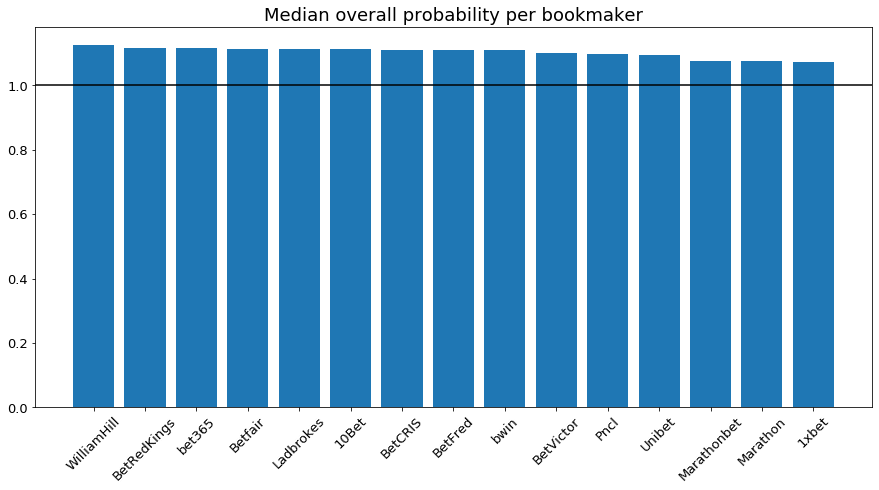

In [28]:
fig, ax = plt.subplots(figsize=(15, 7))
median_probabilities = fixtures_and_odds.groupby('bookmaker_name')['overall_probability'].median().sort_values(ascending=False)
ax.bar(median_probabilities.index, median_probabilities.values)
ax.axhline(1, color='black')
plt.title('Median overall probability per bookmaker')
plt.xticks(rotation=45)
plt.show()

In [30]:
fixtures_and_odds.head()

,id,league_id,season_id,stage_id,round_id,group_id,aggregate_id,venue_id,referee_id,localteam_id,...,flatOdds,odd_name,odd_value,odd_winning,bookmaker_name,date_time,localteam_name,visitorteam_name,overall_probability,odd_name_bookmaker
0,10367580,564,13133,7743270,151245,NaN,NaN,9345,13525.0,231,...,"[{'bookmaker_id': 2, 'bookmaker_event_id': Non...",1,2.00,False,bet365,2018-08-17 20:15:00,Girona,Real Valladolid,1.127193,1_bet365
1,10367580,564,13133,7743270,151245,NaN,NaN,9345,13525.0,231,...,"[{'bookmaker_id': 2, 'bookmaker_event_id': Non...",X,2.40,True,bet365,2018-08-17 20:15:00,Girona,Real Valladolid,1.127193,X_bet365
2,10367580,564,13133,7743270,151245,NaN,NaN,9345,13525.0,231,...,"[{'bookmaker_id': 2, 'bookmaker_event_id': Non...",2,4.75,False,bet365,2018-08-17 20:15:00,Girona,Real Valladolid,1.127193,2_bet365
3,10367580,564,13133,7743270,151245,NaN,NaN,9345,13525.0,231,...,"[{'bookmaker_id': 2, 'bookmaker_event_id': Non...",1,2.11,False,Marathonbet,2018-08-17 20:15:00,Girona,Real Valladolid,1.075954,1_Marathonbet
4,10367580,564,13133,7743270,151245,NaN,NaN,9345,13525.0,231,...,"[{'bookmaker_id': 2, 'bookmaker_event_id': Non...",2,4.95,False,Marathonbet,2018-08-17 20:15:00,Girona,Real Valladolid,1.075954,2_Marathonbet


Text(0.5, 1.0, 'Distribution of overall probability for all games with bwin odds')

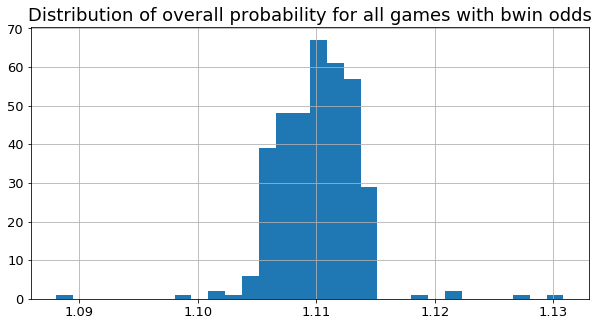

In [35]:
bookmaker = 'bwin'
fixtures_and_odds.loc[fixtures_and_odds['bookmaker_name'] == bookmaker].groupby('id').first()['overall_probability'].hist(figsize=(10, 5), bins=30)
plt.title(f'Distribution of overall probability for all games with {bookmaker} odds')

In [11]:
fixtures_and_odds.head()

,id,league_id,season_id,stage_id,round_id,group_id,aggregate_id,venue_id,referee_id,localteam_id,...,flatOdds,odd_name,odd_value,odd_winning,bookmaker_name,date_time,localteam_name,visitorteam_name,overall_probability,odd_name_bookmaker
0,10367580,564,13133,7743270,151245,NaN,NaN,9345,13525.0,231,...,"[{'bookmaker_id': 2, 'bookmaker_event_id': Non...",1,2.00,False,bet365,2018-08-17 20:15:00,Girona,Real Valladolid,1.127193,1_bet365
1,10367580,564,13133,7743270,151245,NaN,NaN,9345,13525.0,231,...,"[{'bookmaker_id': 2, 'bookmaker_event_id': Non...",X,2.40,True,bet365,2018-08-17 20:15:00,Girona,Real Valladolid,1.127193,X_bet365
2,10367580,564,13133,7743270,151245,NaN,NaN,9345,13525.0,231,...,"[{'bookmaker_id': 2, 'bookmaker_event_id': Non...",2,4.75,False,bet365,2018-08-17 20:15:00,Girona,Real Valladolid,1.127193,2_bet365
3,10367580,564,13133,7743270,151245,NaN,NaN,9345,13525.0,231,...,"[{'bookmaker_id': 2, 'bookmaker_event_id': Non...",1,2.11,False,Marathonbet,2018-08-17 20:15:00,Girona,Real Valladolid,1.075954,1_Marathonbet
4,10367580,564,13133,7743270,151245,NaN,NaN,9345,13525.0,231,...,"[{'bookmaker_id': 2, 'bookmaker_event_id': Non...",2,4.95,False,Marathonbet,2018-08-17 20:15:00,Girona,Real Valladolid,1.075954,2_Marathonbet


In [20]:
fixtures_and_odds.iloc[0]

id                                                                  10367580
league_id                                                                564
season_id                                                              13133
stage_id                                                             7743270
round_id                                                              151245
group_id                                                                 NaN
aggregate_id                                                             NaN
venue_id                                                                9345
referee_id                                                             13525
localteam_id                                                             231
visitorteam_id                                                           361
winner_team_id                                                           NaN
weather_report             {'code': 'clouds', 'type': 'scattered clouds',...

In [18]:
fixtures_and_odds.groupby(['bookmaker_name', 'odd_name'])[['odd_value']].mean().pivot(index='bookmaker_name')#.plot(kind='bar', figsize=(30, 10))

KeyError: 'bookmaker_name'

In [ ]:
fixtures.groupby('odd_name')

In [6]:
# Who's the best at correctly predicting the outcomes? 

In [12]:
bookmaker_predictions = fixtures_and_odds.groupby(['bookmaker_name', 'id']).apply(lambda x: x.loc[x['odd_value'].idxmax(), ['odd_name']])
bookmaker_predictions.head()

odd_name
bookmaker_name id               
10Bet          10367596        1
               10367597        2
               10367598        1
               10367599        1
               10367600        2

In [18]:
fixtures_and_odds.loc[(fixtures_and_odds['id'] == 10367596) & (fixtures_and_odds['odd_winning']), 'odd_name'].head()

9300    1
9303    1
9306    1
9309    1
9312    1
Name: odd_name, dtype: object

In [45]:
# This 
results = pd.DataFrame(
    fixtures_and_odds.set_index(['localteam_id', 'id']).apply(get_single_result, axis=1).map({'draw': 'X', 'loss': '0', 'win': '1'}).groupby('id').first(),
    fixtures_and_odds.groupby('id')[''].first(),    
    columns=['result'])
print(results.shape)
results.head()

(640, 1)


,result
id,
10367576,1
10367578,X
10367579,0
10367580,X
10367581,0


In [47]:
bookmaker_predictions = fixtures_and_odds.groupby(['bookmaker_name', 'id']).apply(lambda x: x.loc[x['odd_value'].idxmin(), ['odd_name']])
print(bookmaker_predictions.shape)
bookmaker_predictions.head()

(4312, 1)


odd_name
bookmaker_name id               
10Bet          10367596        X
               10367597        1
               10367598        X
               10367599        X
               10367600        1

In [48]:
results_and_predictions = results.join(bookmaker_predictions, how='outer')

In [49]:
results_and_predictions.head()

result odd_name
bookmaker_name id                      
10Bet          10367596      1        X
               10367597      1        1
               10367598      1        X
               10367599      1        X
               10367600      X        1